# Jupyter notebook template for Assignment 4

We start by loading the necessary packages. Feel free to add more as needed.

In [1]:
# Importing packages -- feel free to add more, but recall that you should not use built-in 
# functions for the task at hand. If in doubt, ask us by email.
from scipy import signal as sg
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io
from skimage import color
from matplotlib import cm 
import matplotlib
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['figure.dpi']=150

Populating the interactive namespace from numpy and matplotlib


### Exercise 2
First, we load the data

In [2]:
data = np.loadtxt('data/precipitation.txt')
#print(data)

OSError: data/precipitation.txt not found.

In the box below, provide your implementation of a numerical estimation of the integral from the exercise

In [1]:
def evenIntegral(inArr):
    return sum(inArr)

print("Integral up to 182:\t\t", evenIntegral(data[:182]))
print("Integral of entire set:\t\t",evenIntegral(data))

NameError: name 'data' is not defined

### Exercise 4

Start out by loading (and, if you like, viewing) the images to be used

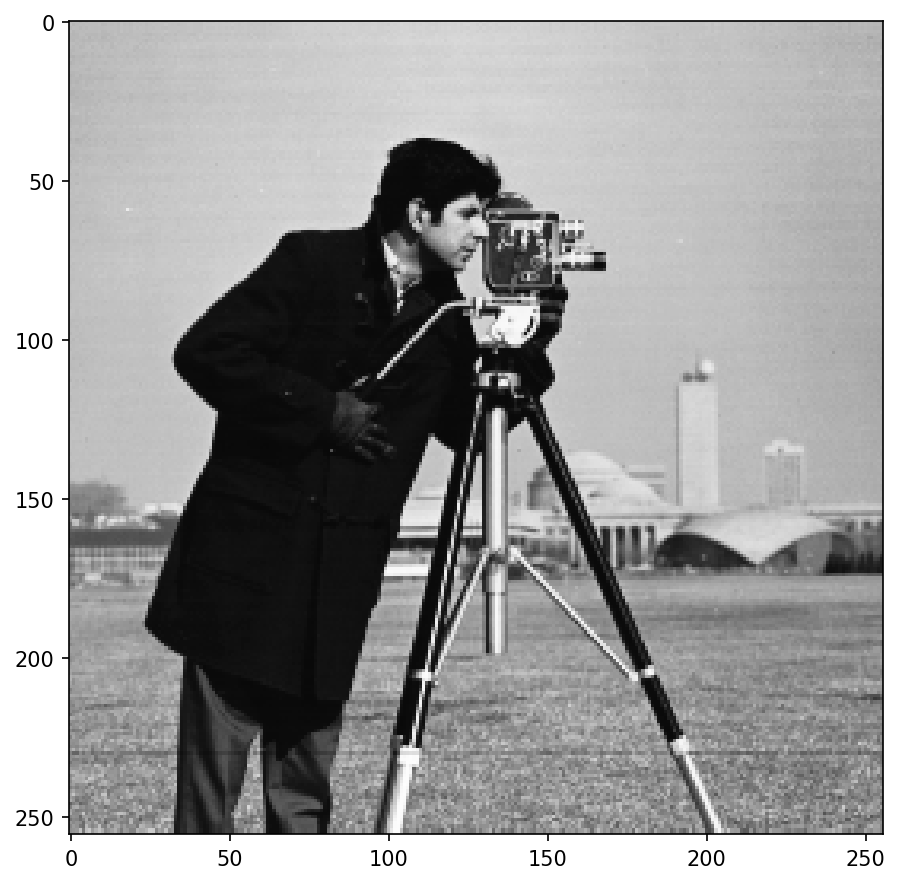

In [56]:
# Read and view the coins.png image
coin = color.rgb2gray(io.imread('data/coins.png'))

# Uncomment if, alternatively, you want to test with the cameraman.png image
f = io.imread('data/cameraman.png')

# Uncomment if you want to view the image:
io.imshow(f, cmap=cm.Greys_r) 

### Exercise 4a) 

In the box below:
* blur the image by convolving it with a Gaussian with standard deviation $\sigma = 1.4$. Your Gaussian convolving element $g$ should be a $5 \times 5$ matrix

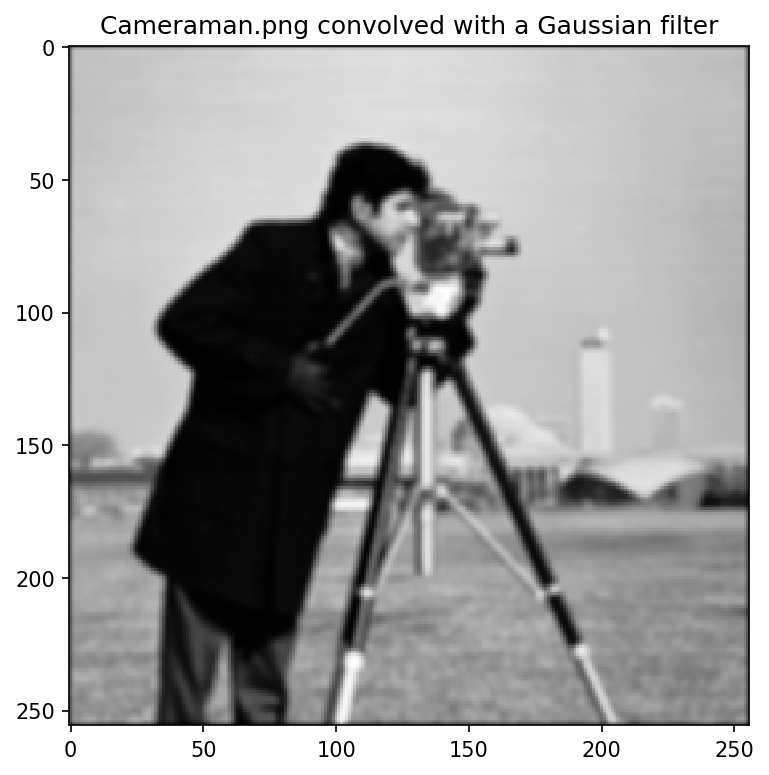

Text(0.5,1,'Coins.png convolved with a Gaussian filter')

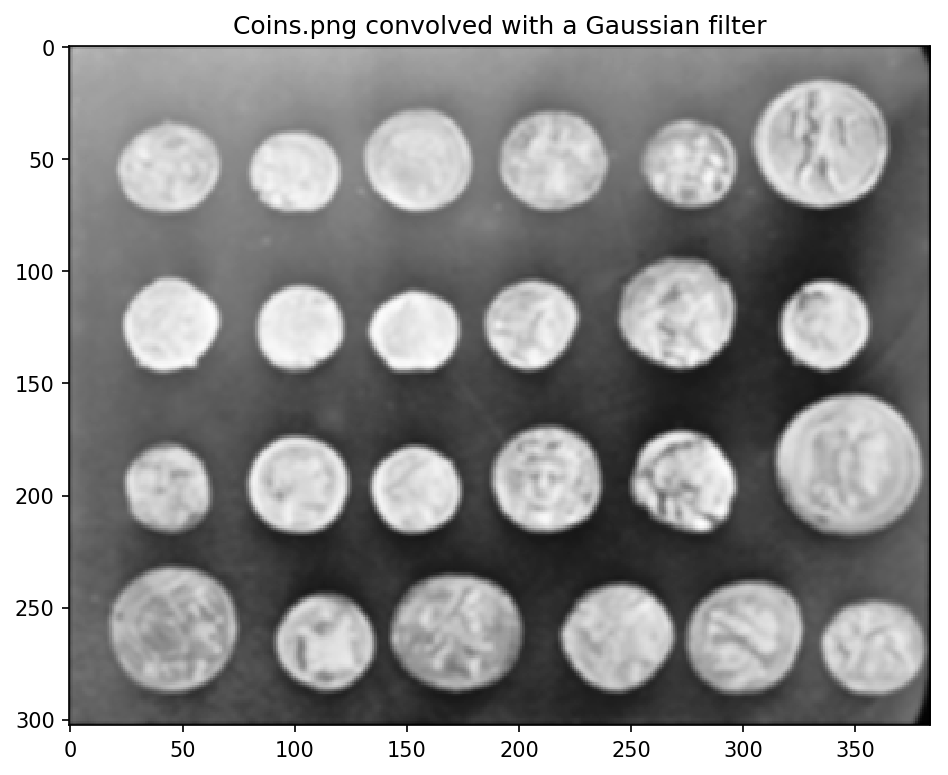

In [57]:
def convolve(image):
    sigma = 1.4
    X, Y = np.mgrid[-2:3, -2:3]
    g = np.exp(-(X**2 + Y**2)/(2*sigma**2))
    g /= g.sum()
    return sg.convolve2d(image, g, mode='same')
    
plt.imshow(convolve(f), cmap=cm.Greys_r)
plt.title('Cameraman.png convolved with a Gaussian filter')
plt.show()

plt.imshow(convolve(coin), cmap=cm.Greys_r)
plt.title('Coins.png convolved with a Gaussian filter')

### Exercise 4b) 
In the box below:
* implement a Sobel approximation of the partial derivatives with respect to x and y as described in the exercise,
* implement a Sobel approximation of the gradient magnitude
* apply them all to the result from a)

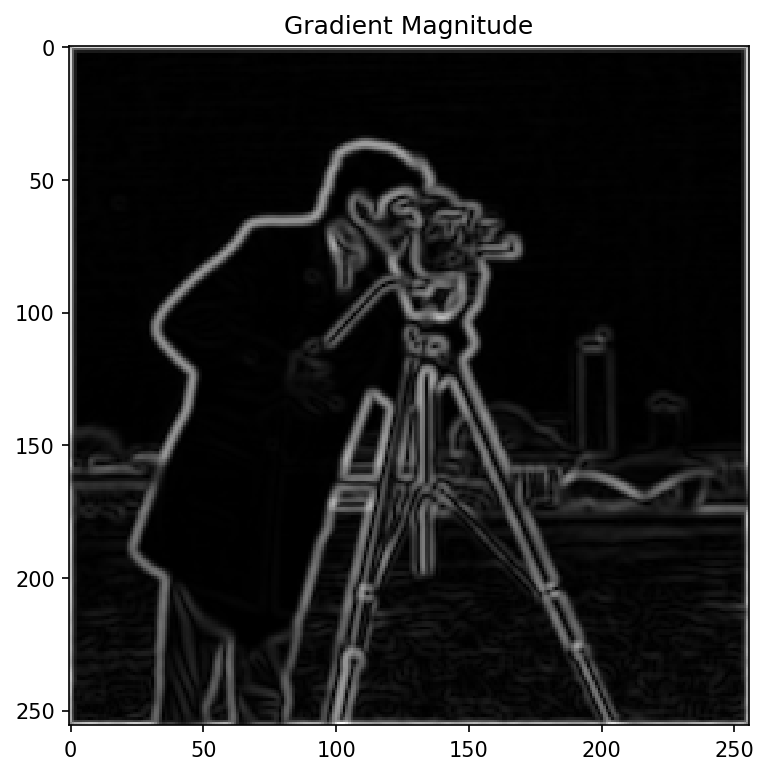

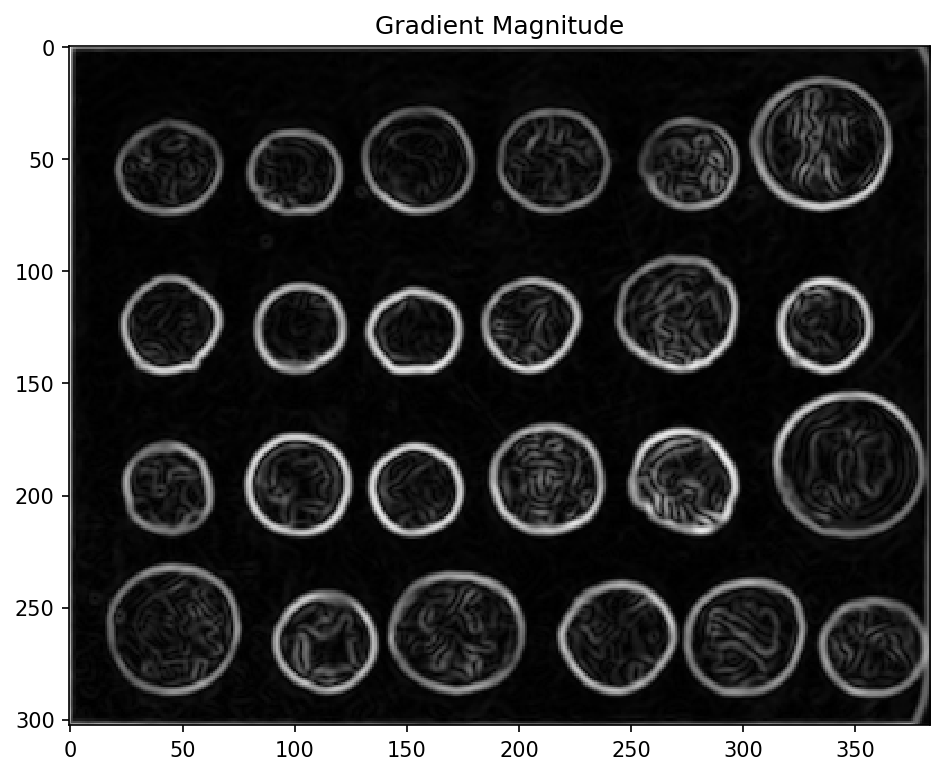

In [58]:
gx = np.matrix([[1, 0, -1],
                [2, 0, -2],
                [1, 0, -1]])
gy = np.matrix([[-1,-2,-1,],
                [ 0, 0, 0],
                [ 1, 2, 1]])

def sobelD(image, matrix):
    return sg.convolve2d(image, matrix, mode='same')

def gradeMag(image):
    N, M = image.shape

    tempXDiff = sobelD(image, gx)
    tempYDiff = sobelD(image, gy)
    newImage = np.sqrt(tempXDiff**2 + tempYDiff**2)

    return newImage


plt.title("Gradient Magnitude")
plt.imshow(gradeMag(convolve(f)), cmap=cm.Greys_r)

plt.show()
plt.title("Gradient Magnitude")
plt.imshow(gradeMag(convolve(coin)), cmap=cm.Greys_r)

### Exercise 4c) 
In the box below, implement non-maximum suppression as follows:
* in every pixel of the image, use your partial derivatives from b) to compute the angle of the gradient
* round the gradient to the nearest 45 degrees
* for each pixel in the gradient magnitude image from b):
    * use your rounded gradient in that pixel to identify the two neighboring pixels in the forward and backward direction of the gradient.
    * if the value of your gradient magnitude is larger in your fixed pixel than in the two neighbors, keep it. If one of your neighboring pixels has a higher value of the gradient magnitude, then set it to 0.
    
Iterate through every pixel of the gradient image, keeping those values that are maximal and setting those to 0 that are not. It is OK to skip the pixels along the edge of the image.
*  Visualize the resulting image.

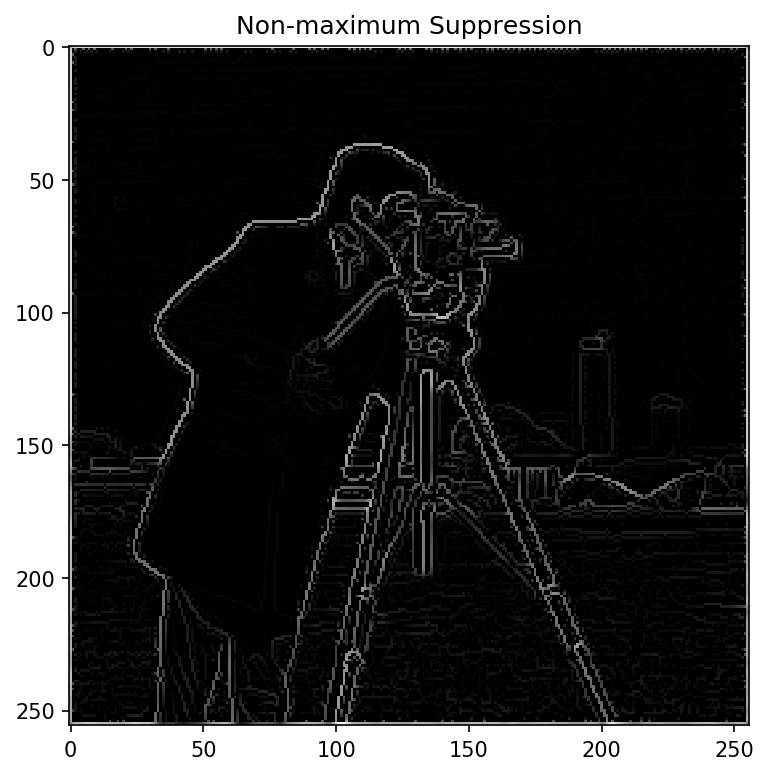

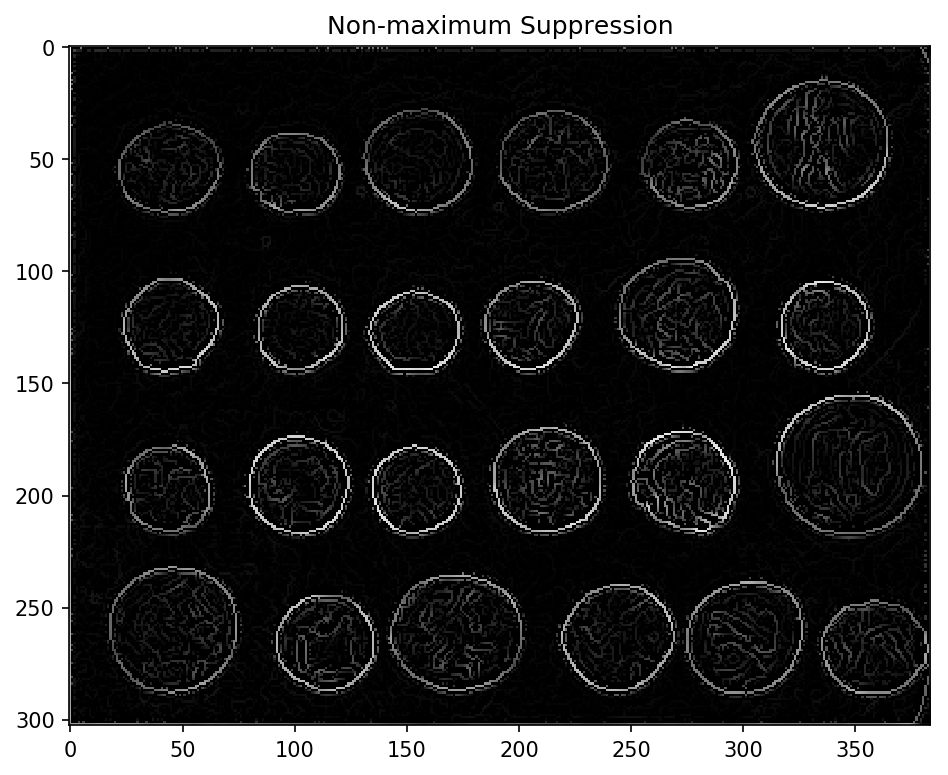

In [59]:
def nMSuppr(image):
    X,Y = image.shape
    #print(X)
    xImg = sobelD(image, gx)
    yImg = sobelD(image, gy)
    magImg = gradeMag(convolve(image))
    
    for i in range(X-1):
        for j in range(Y-1):
            if (j > 0 and i > 0):
                
                if (xImg[i,j] == 0):
                    angle = 0
                else:
                    angle = np.degrees(arctan(yImg[i,j]/xImg[i,j]))
                    angle = round(angle/45)*45
                    
                if (angle == 45 and (magImg[i,j] <= magImg[i+1,j-1] or magImg[i,j] <= magImg[i-1,j+1])):
                    magImg[i,j] = 0
                elif(angle == -45 and (magImg[i,j] <= magImg[i+1,j+1] or magImg[i,j] <= magImg[i-1,j-1])):
                    magImg[i,j] = 0
                elif ((angle == 0 or angle == -0) and (magImg[i,j] <= magImg[i,j+1] or magImg[i,j] <= magImg[i,j-1])):
                    magImg[i,j] = 0
                elif ((angle == 90 or angle == -90) and (magImg[i,j] <= magImg[i+1,j] or magImg[i,j] <= magImg[i-1,j])):
                    magImg[i,j] = 0
    return magImg

f = io.imread('data/cameraman.png')

plt.title("Non-maximum Suppression")
plt.imshow(nMSuppr(f), cmap=cm.Greys_r)

plt.show()
coin = color.rgb2gray(io.imread('data/coins.png'))

plt.title("Non-maximum Suppression")
plt.imshow(nMSuppr(coin), cmap=cm.Greys_r)

### 4d) 
In the box below:
* Normalize the output image from c) by dividing by its maximal value. 
* Classify all pixels in the normalized gradient image with intensity higher than 0.7, as *strong* edge pixels; those with intensity between 0.3 and 0.7, as *weak* edge pixels; and those with intensity below 0.3 as *non-edge* pixels. 
* Visualize your pixel classification as an image with intensity 255 for the strong edges, intensity 100 for the weak edges, and intensity 0 for the non-edges.

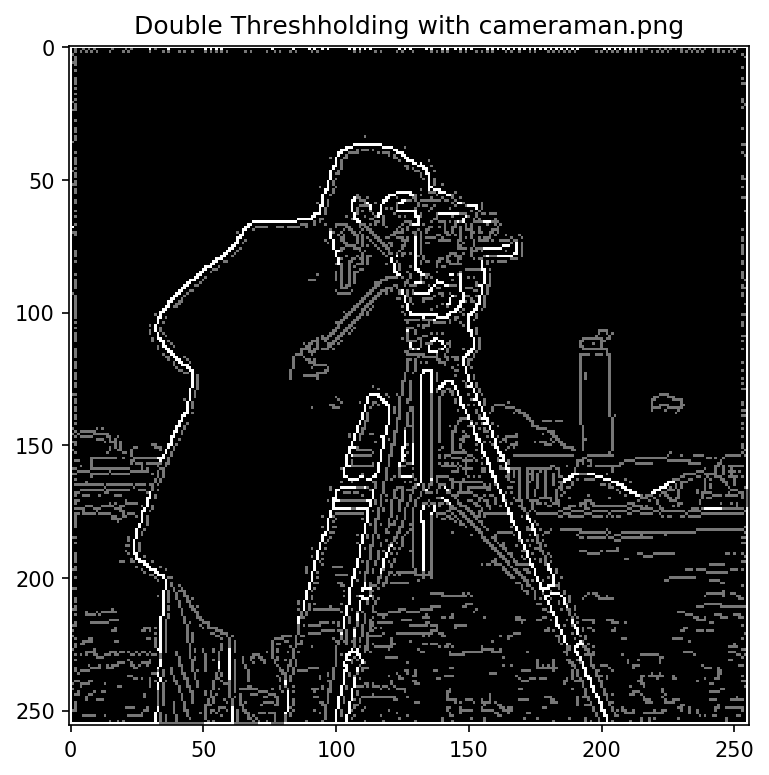

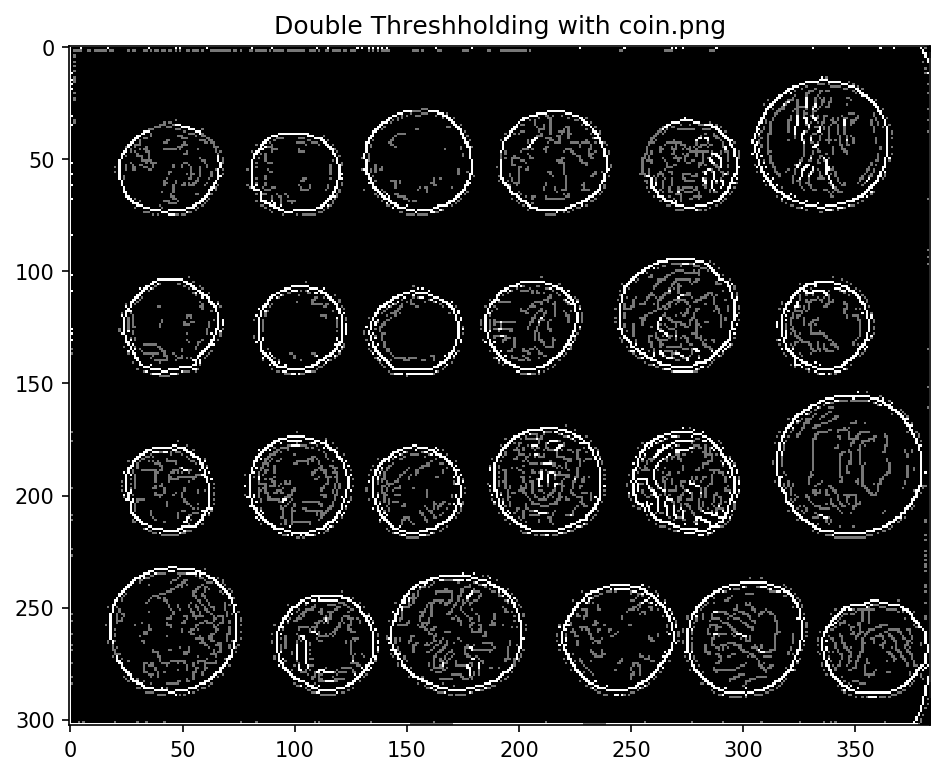

In [60]:
def dbThr(image, min_t, max_t):
    
    X,Y = convolve(image).shape
    supprImg = nMSuppr(image)
    maxVal = 0
    
    for i in range(X):
        for j in range(Y):
            if supprImg[i,j] > maxVal:
                maxVal = supprImg[i,j]
    
    for i in range(X):
        for j in range(Y):
            supprImg[i,j] = supprImg[i,j]/maxVal
            if (supprImg[i,j] > max_t):
                image[i,j] = 255
            elif (supprImg[i,j] < min_t):
                image[i,j] = 0
            else:
                image[i,j] = 100
    return image

f = io.imread('data/cameraman.png')

plt.title('Double Threshholding with cameraman.png')
plt.imshow(dbThr(f, 0.05, 0.3), cmap=cm.Greys_r)
plt.show()

coin = io.imread('data/coins.png')

plt.title('Double Threshholding with coin.png')
plt.imshow(dbThr(coin, 0.1, 0.25), cmap=cm.Greys_r)